In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import cupy as cp

In [2]:
data = np.load("/content/drive/MyDrive/Copy of train_features_alexnet.npz")
X_train = data["features"]
y_train = data["labels"]
data = np.load("/content/drive/MyDrive/Copy of test_features_alexnet.npz")
X_test = data["features"]
y_test = data["labels"]

In [ ]:
# for solving Ram Problem
del data

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alexnet = models.alexnet(pretrained=True)
classifier = alexnet.classifier

num_classes = 10
classifier[-1] = nn.Linear(4096, num_classes)

model = nn.Sequential(
    classifier
).to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 184MB/s]


In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100
train_losses = []
val_accuracies = []
inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
labels =  torch.tensor(y_train, dtype=torch.long).to(device)

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
  labels =  torch.tensor(y_train, dtype=torch.long).to(device)

  optimizer.zero_grad()
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  running_loss += loss.item()
  train_losses.append(running_loss)

  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    inputs_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    labels_test =  torch.tensor(y_test, dtype=torch.long).to(device)
    outputs = model(inputs_test)
    preds = torch.argmax(outputs, dim=1)
    correct += (preds == labels_test).sum().item()
    total += labels_test.size(0)
  acc = correct / total
  val_accuracies.append(acc)
  print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Val Acc: {acc:.4f}")

Epoch 1, Loss: 2.3365, Val Acc: 0.1699
Epoch 2, Loss: 2.2396, Val Acc: 0.2331
Epoch 3, Loss: 2.1596, Val Acc: 0.2733
Epoch 4, Loss: 2.0833, Val Acc: 0.3090
Epoch 5, Loss: 2.0138, Val Acc: 0.3237
Epoch 6, Loss: 1.9472, Val Acc: 0.3404
Epoch 7, Loss: 1.8813, Val Acc: 0.3521
Epoch 8, Loss: 1.8235, Val Acc: 0.3716
Epoch 9, Loss: 1.7620, Val Acc: 0.3902
Epoch 10, Loss: 1.7003, Val Acc: 0.4058
Epoch 11, Loss: 1.6508, Val Acc: 0.4144
Epoch 12, Loss: 1.5971, Val Acc: 0.4265
Epoch 13, Loss: 1.5467, Val Acc: 0.4410
Epoch 14, Loss: 1.5022, Val Acc: 0.4553
Epoch 15, Loss: 1.4557, Val Acc: 0.4663
Epoch 16, Loss: 1.4104, Val Acc: 0.4793
Epoch 17, Loss: 1.3680, Val Acc: 0.4940
Epoch 18, Loss: 1.3225, Val Acc: 0.5085
Epoch 19, Loss: 1.2876, Val Acc: 0.5172
Epoch 20, Loss: 1.2461, Val Acc: 0.5267
Epoch 21, Loss: 1.2060, Val Acc: 0.5395
Epoch 22, Loss: 1.1666, Val Acc: 0.5507
Epoch 23, Loss: 1.1315, Val Acc: 0.5618
Epoch 24, Loss: 1.0956, Val Acc: 0.5683
Epoch 25, Loss: 1.0600, Val Acc: 0.5750
Epoch 26,

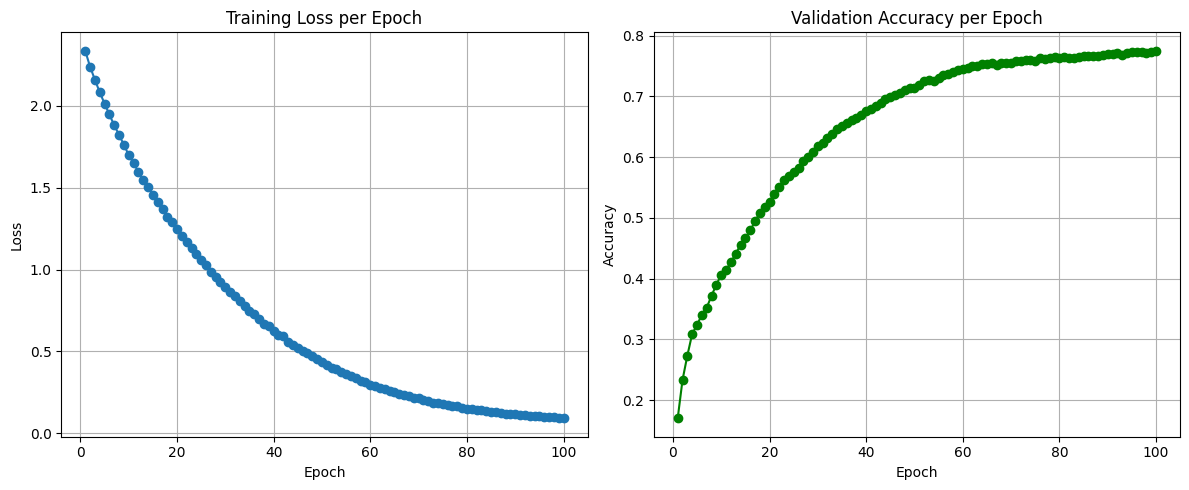

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='o', color='green')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


🔍 Final Evaluation Metrics:
Accuracy : 0.7752
Precision: 0.7759
Recall   : 0.7751
F1 Score : 0.7751


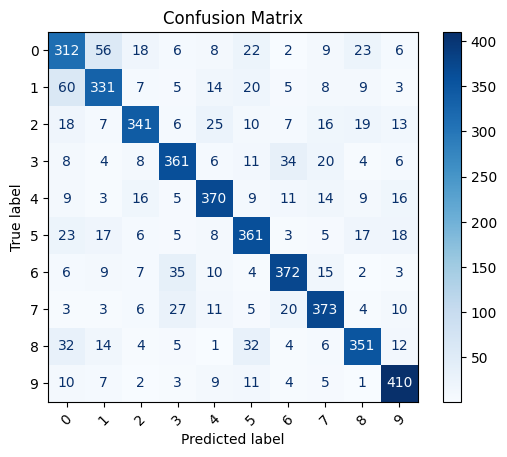

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Code from ChatGpt for clean calculation of metrics
inputs_test = torch.tensor(X_test, dtype=torch.float32).to(device)
labels_test = torch.tensor(y_test, dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(inputs_test)
    preds = torch.argmax(outputs, dim=1)

y_true = labels_test.cpu().numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n🔍 Final Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()